# Adult Census Income Prediction

## Project Goal

The goal of this project is to predict whether an individual's income exceeds $50,000 per year based on census data. This notebook will cover the entire machine learning pipeline, from data loading and cleaning to exploratory data analysis (EDA), feature engineering, and finally, model training and evaluation.

We will focus on building a robust and reproducible workflow, using a custom library for preprocessing and analysis, and providing clear visualizations and explanations at each step.

# Main Notebook
This notebook is for the main analysis and experimentation.

In [30]:
# Enable autoreloading of imported modules
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Add the repo root to access the courselib
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
courselib_path = os.path.join(repo_root, "AppliedML", "courselib")
if courselib_path not in sys.path:
    sys.path.insert(0, courselib_path)
    print(f"{courselib_path} added to sys.path.")
else:
    print("Courselib path already in sys.path.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Courselib path already in sys.path.


As this project is supposed to integrate well with the courselib, we have downloaded the current GitHub Repo up to week 11 and our code will be integrated within courselib libraries.

In [31]:
from utils.loaders import load_uciadult

# ensure the data directory exists / else create it
os.makedirs('data', exist_ok=True)

# get the data
df = load_uciadult()

Loading from local `data/adult.data`...


In [32]:
# check for missing values
df.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

### Data Cleaning

1.  **Handle Duplicates**: We remove any duplicate rows from the dataset.
2.  **Handle Missing Values**: Instead of removing rows with missing data, we treat the missing values in our categorical columns as a distinct category called 'Missing' as these observations could also contain additional information, expecially when condisering their categorical nature.


In [33]:
from utils.preprocessing import preprocess_data

# preprocessing of  the data
df = preprocess_data(df)


24 duplicate observations in the dataset were removed.


c:\Users\janne\Google Drive\Master 2\AML\github_code\final_project\AML---final-project\AppliedML\courselib\utils\preprocessing.py:72: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




# Exploratory Data Analysis

In [34]:
# basic info about the data set 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32537 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32537 non-null  int64 
 1   workclass       32537 non-null  object
 2   fnlwgt          32537 non-null  int64 
 3   education       32537 non-null  object
 4   education-num   32537 non-null  int64 
 5   marital-status  32537 non-null  object
 6   occupation      32537 non-null  object
 7   relationship    32537 non-null  object
 8   race            32537 non-null  object
 9   sex             32537 non-null  object
 10  capital-gain    32537 non-null  int64 
 11  capital-loss    32537 non-null  int64 
 12  hours-per-week  32537 non-null  int64 
 13  native-country  32537 non-null  object
 14  income          32537 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 4.0+ MB


In [35]:
# summary stats about the variables
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income
count,32537.000000,3.253700e+04,32537.000000,32537.000000,32537.000000,32537.000000,32537.000000
mean,38.585549,1.897808e+05,10.081815,1078.443741,87.368227,40.440329,0.240926
std,13.637984,1.055565e+05,2.571633,7387.957424,403.101833,12.346889,0.427652
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.369930e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


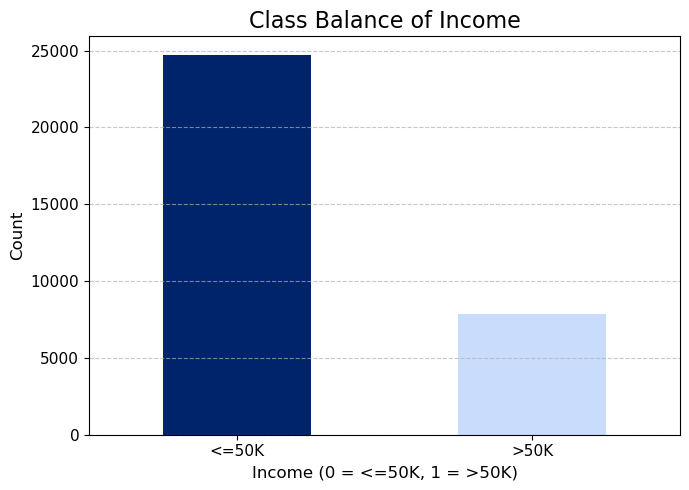

In [66]:
# distribution of the target variable
plt.figure(figsize=(7, 5))
bars = df['income'].value_counts().sort_index().plot(
    kind='bar',
    color=['#00246B', '#CADCFC'],
)
plt.title('Class Balance of Income', fontsize=16)
plt.xlabel('Income (0 = <=50K, 1 = >50K)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['<=50K', '>50K'], rotation=0, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

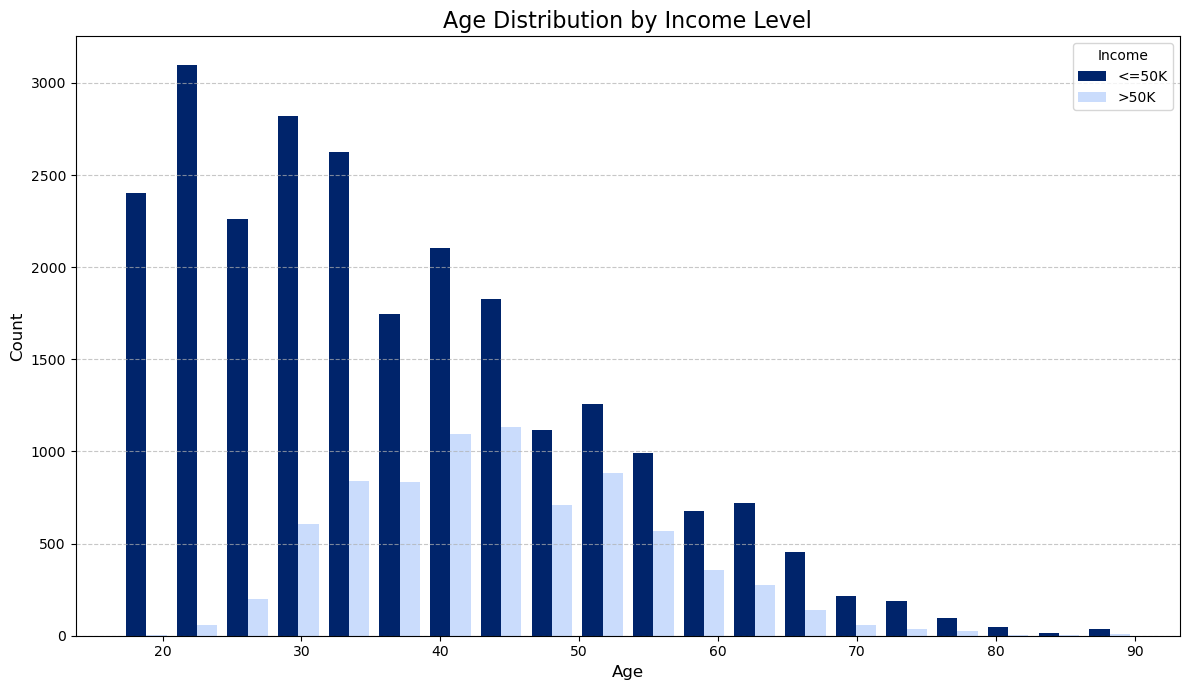

In [67]:
# relationship between income and age
plt.figure(figsize=(12, 7))

# Separate data for the two income categories
over50k = df[df['income'] == 0]['age']
below50k = df[df['income'] == 1]['age']

# side-by-side histograms
plt.hist([over50k, below50k], bins=20, color=['#00246B', '#CADCFC'], label=['<=50K', '>50K'])

# Customize the plot
plt.title('Age Distribution by Income Level', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Income')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

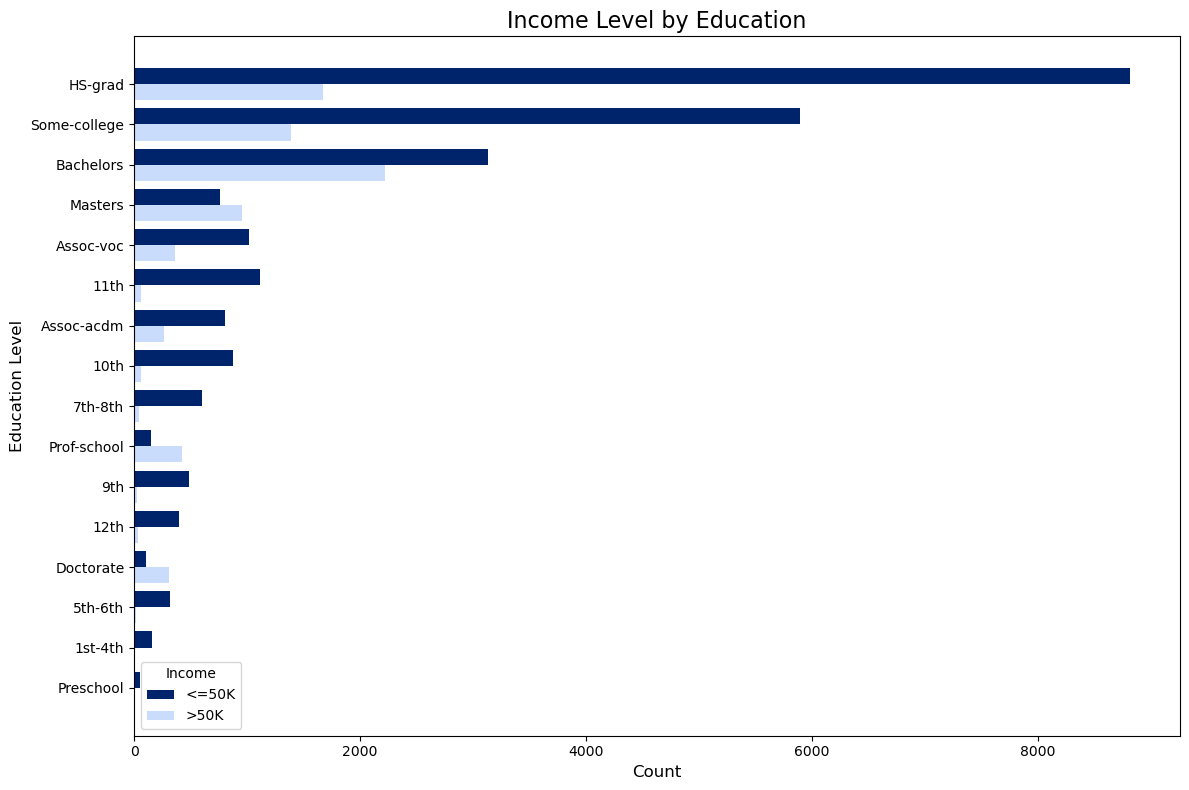

In [68]:
# income by education

# Prepare data for grouped bar chart
education_order = df['education'].value_counts().index
income_by_education = pd.crosstab(df['education'], df['income'])
income_by_education = income_by_education.reindex(education_order)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.4
y_pos = np.arange(len(income_by_education.index))

# Plot bars for income <=50K (0) and >50K (1)
ax.barh(y_pos - bar_width/2, income_by_education[0], height=bar_width, color='#00246B', label='<=50K')
ax.barh(y_pos + bar_width/2, income_by_education[1], height=bar_width, color='#CADCFC', label='>50K')

# Customization
ax.set_yticks(y_pos)
ax.set_yticklabels(income_by_education.index)
ax.invert_yaxis()  # To match the value_counts() order
ax.set_title('Income Level by Education', fontsize=16)
ax.set_xlabel('Count', fontsize=12)
ax.set_ylabel('Education Level', fontsize=12)
ax.legend(title='Income')
plt.tight_layout()
plt.show()

In [ ]:
# first glimpse into the data set
df.head(20)

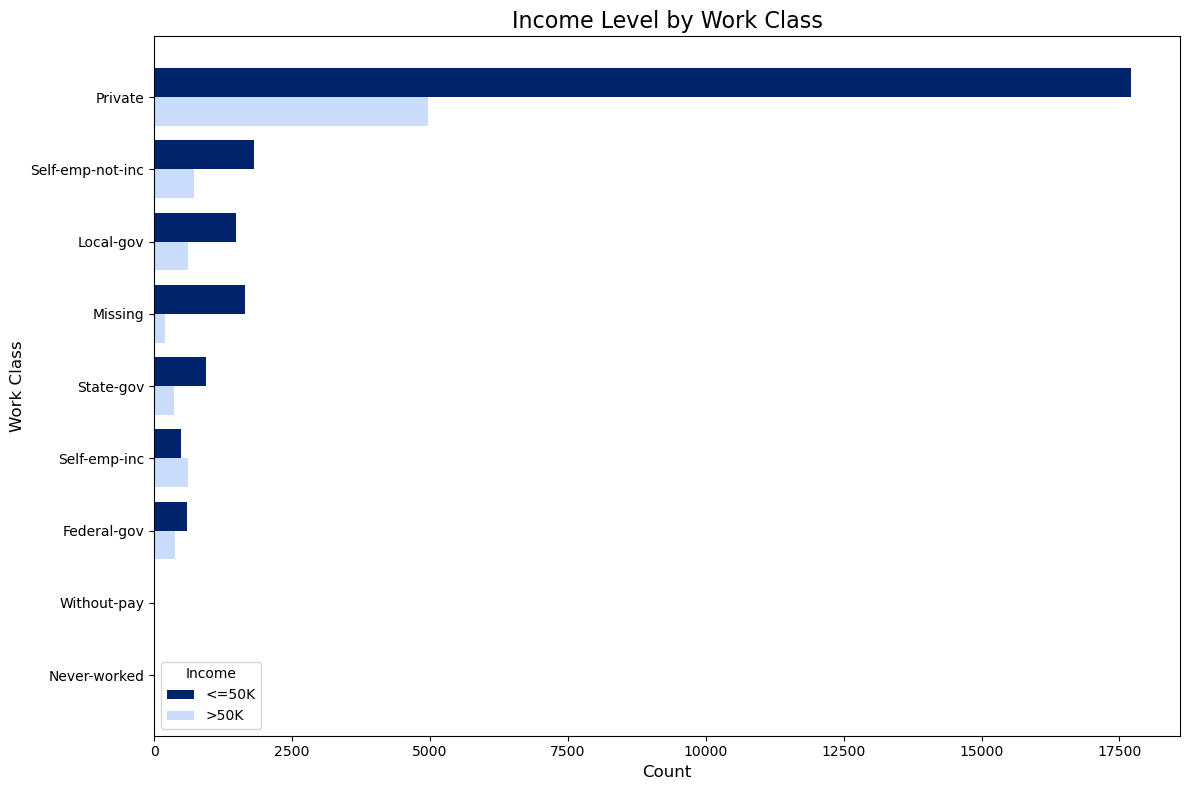

In [70]:
# income by workclass
workclass_order = df['workclass'].value_counts().index
income_by_workclass = pd.crosstab(df['workclass'], df['income'])
income_by_workclass = income_by_workclass.reindex(workclass_order)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.4
y_pos = np.arange(len(income_by_workclass.index))

# Plot bars for income <=50K (0) and >50K (1)
ax.barh(y_pos - bar_width/2, income_by_workclass[0], height=bar_width, color='#00246B', label='<=50K')
ax.barh(y_pos + bar_width/2, income_by_workclass[1], height=bar_width, color='#CADCFC', label='>50K')

# Customization
ax.set_yticks(y_pos)
ax.set_yticklabels(income_by_workclass.index)
ax.invert_yaxis()  # To match the value_counts() order
ax.set_title('Income Level by Work Class', fontsize=16)
ax.set_xlabel('Count', fontsize=12)
ax.set_ylabel('Work Class', fontsize=12)
ax.legend(title='Income')
plt.tight_layout()
plt.show()

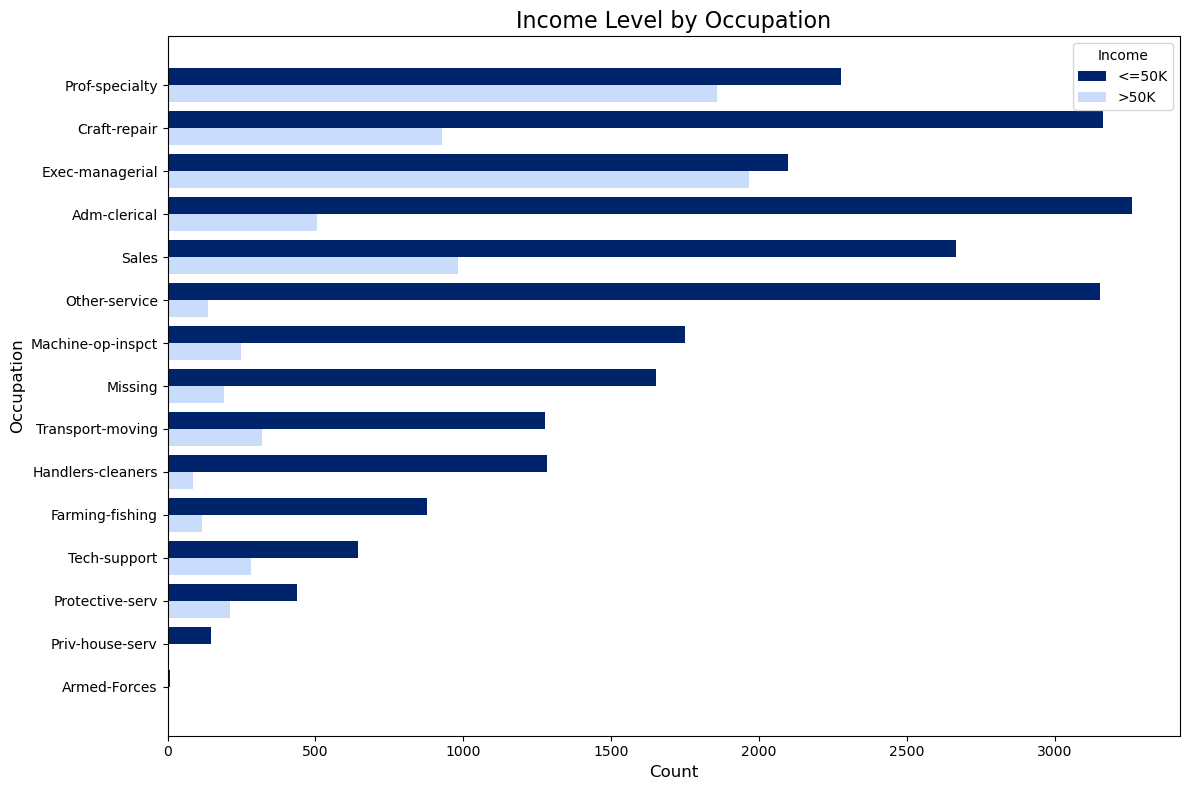

In [73]:

# Prepare data for grouped bar chart
occupation_order = df['occupation'].value_counts().index
income_by_occupation = pd.crosstab(df['occupation'], df['income'])
income_by_occupation = income_by_occupation.reindex(occupation_order)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.4
y_pos = np.arange(len(income_by_occupation.index))

# Plot bars for income <=50K (0) and >50K (1)
ax.barh(y_pos - bar_width/2, income_by_occupation[0], height=bar_width, color='#00246B', label='<=50K')
ax.barh(y_pos + bar_width/2, income_by_occupation[1], height=bar_width, color='#CADCFC', label='>50K')

# Customization
ax.set_yticks(y_pos)
ax.set_yticklabels(income_by_occupation.index)
ax.invert_yaxis()  # To match the value_counts() order
ax.set_title('Income Level by Occupation', fontsize=16)
ax.set_xlabel('Count', fontsize=12)
ax.set_ylabel('Occupation', fontsize=12)
ax.legend(title='Income')
plt.tight_layout()
plt.show()


# Feature Engineering


### How Feature Encoding Works

Feature encoding is a crucial step in preparing data for machine learning models. Most models require numerical input, so we need to convert categorical features (text-based) into a numerical format. The `encode_features` function from our `courselib` library is designed to handle this process in a structured and flexible way.

It acts as a central dispatcher, reading a dictionary called `encoding_strategies` to determine which encoding method to apply to which columns. This approach allows us to easily experiment with different strategies without changing the underlying code.

Here’s a breakdown of the encoding methods used in this project:

#### 1. One-Hot Encoding

- **What it is**: This technique converts a categorical feature with *k* unique categories into *k-1* new binary (0 or 1) columns. Each column represents one category, and a `1` indicates that the observation belongs to that category. We use *k-1* columns to avoid multicollinearity (the "dummy variable trap"), where the last category can be inferred from the others.
- **Mathematical Definition**: For a category *c*, its one-hot representation is a vector `v` of length *k-1*, where `v[i] = 1` if the observation belongs to category *i*, and `0` otherwise.
- **How it's implemented**: The `one_hot_encode` function is called for the columns specified under the `'one-hot'` key. It uses our custom `labels_encoding` utility to create the binary matrix.
- **When to use it**: It is ideal for **nominal** features, where categories have no intrinsic order (e.g., `sex`, `race`).
- **Columns in this project**: `workclass`, `marital-status`, `relationship`, `race`, `sex`.

#### 2. Ordinal Encoding

- **What it is**: This method assigns a unique integer to each category based on a predefined, meaningful order. For example, 'Preschool' might be `0`, 'HS-grad' might be `8`, and 'Doctorate' might be `12`.
- **Mathematical Definition**: A mapping function `f(c) = i` is defined, where *c* is a category and *i* is its integer representation from a predefined ordered set `{0, 1, ..., k-1}`.
- **How it's implemented**: The `ordinal_encode` function is called. It requires a dictionary where the key is the column name and the value is a list defining the exact order of the categories.
- **When to use it**: It is used for **ordinal** features, where the order of categories is important (e.g., education levels, ratings).
- **Column in this project**: `education`.

#### 3. Target Encoding

- **What it is**: This powerful technique replaces each category with the average value of the target variable for that category. For instance, the category 'Exec-managerial' in the `occupation` column would be replaced by the average income of all executive managers in the dataset.
- **Mathematical Definition**: The encoded value for a category *c* is `E(c) = mean(y | X=c)`, where *y* is the target variable. To prevent data leakage, this mean is typically calculated on a subset of the data (e.g., using cross-validation).
- **How it's implemented**: The `target_encode` function is called. To prevent **data leakage** (where information from the target variable unfairly influences the model), our implementation uses a robust cross-validation scheme. The data is split into folds, and the encoding for each fold is calculated using the target means from the *other* folds. This ensures the encoding is based on data the model hasn't "seen" during training.
- **When to use it**: It is particularly effective for **high-cardinality** features (columns with many unique categories), like `occupation` or `native-country`, where one-hot encoding would create too many new columns.
- **Columns in this project**: `occupation`, `native-country`. The `income` column is listed first in the `'target'` list to tell the function that it is the target variable.

#### 4. Frequency Encoding

- **What it is**: This method replaces each category with its frequency or the percentage of times it appears in the dataset. It assumes that the frequency of a category is a useful piece of information for the model.
- **Mathematical Definition**: The encoded value for a category *c* is `Freq(c) = count(c) / N`, where `count(c)` is the number of times category *c* appears and *N* is the total number of observations.
- **How it's implemented**: The `frequency_encode` function is called for columns specified under the `'frequency'` key.
- **When to use it**: Like target encoding, it's a good option for **high-cardinality** features. It's simpler than target encoding as it doesn't use the target variable, thus avoiding data leakage.
- **Experimental Plan**: We plan to test frequency encoding on the `native-country` feature as an alternative to target encoding to see which method yields better model performance.

By using this structured approach, our preprocessing pipeline is not only clear and reproducible but also highly customizable for future experiments.

In [74]:
from utils.preprocessing import encode_features

# encoding strategies for each column
encoding_strategies = {
    'one-hot': ['workclass', 'marital-status', 'relationship', 'race', 'sex'],
    'ordinal': {'education': ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th', 'HS-grad',
                               'Some-college', 'Bachelors', 'Masters', 'Doctorate', 'Prof-school', 'Assoc-acdm',
                                 'Assoc-voc']}, # must contain the correct order already
    'target': ['income', 'occupation', 'native-country'],
    # 'frequency': ['native-country'], # to later compare with target encoding
  }

# apply the encoding
df_encoded = encode_features(df.copy(), encoding_strategies)
df_encoded.head()


Applying ordinal encoding...
Applying one-hot encoding...


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income,education_ordinal,workclass_Local-gov,workclass_Missing,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,occupation_target,native-country_target
0,39,77516,13,2174,0,40,0,10,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.143189,0.244078
1,50,83311,13,0,0,13,0,10,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.483476,0.248604
2,38,215646,9,0,0,40,0,8,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.059783,0.244078
3,53,234721,7,0,0,40,0,6,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.057621,0.248604
4,28,338409,13,0,0,40,0,10,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.446802,0.246753


In [43]:
from utils.splits import train_test_split

# returns the full dataset (X, y) as well as the splits
_, _, X_train, y_train, X_test, y_test = train_test_split(
    df_encoded, 
    training_data_fraction=0.8, 
    class_column_name='income',
    shuffle=True, 
    return_numpy=True
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (26029, 33)
X_test shape: (6508, 33)



# Feature Scaling

Before training our models, it's important to scale our numerical features. Of course, it makes no sense to also scale the freshly encoded categorical data, such as the ordinally encoded `education` variable as we would destroy its ordinal structure immediately again.  Models like Logistic Regression are sensitive to the scale of the input data, and scaling can lead to faster convergence and better performance. We will use standardization, where each feature is scaled to have a mean of 0 and a standard deviation of 1.

We will fit the scaler on the training data and use the same scaler to transform the test data. This prevents any information from the test set from leaking into our training process.


In [79]:
from utils.normalization import StandardScaler

# Identify numerical columns for scaling
numerical_cols = ['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']
X_columns = df_encoded.drop('income', axis=1).columns
numerical_indices = [X_columns.get_loc(col) for col in numerical_cols]

# Initialize the scaler with the indices of numerical columns
scaler = StandardScaler(numerical_indices=numerical_indices)

# Fit on training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling complete for numerical columns.")
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)


Feature scaling complete for numerical columns.
X_train_scaled shape: (26030, 33)
X_test_scaled shape: (6507, 33)


In [ ]:
import time
from models.linear_models import LinearBinaryClassification
from models.tree import DecisionTreeClassifier
from utils.metrics import accuracy, confusion_matrix
from optimizers import GDOptimizer

# model params for logistic regression
n_features = X_train_scaled.shape[1]
w_logreg = np.zeros(n_features)
b_logreg = 0
optimizer_logreg = GDOptimizer(learning_rate=0.01)
class_labels_logreg = [0, 1] 

# Define the models to compare
models = {
    'Logistic Regression': LinearBinaryClassification(
        w=w_logreg,
        b=b_logreg,
        optimizer=optimizer_logreg,
        class_labels=class_labels_logreg
    ),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, min_samples_split=2)
}

results = []

# Loop through the models, train, and evaluate
for model_name, model in models.items():
    print(f"--- Training {model_name} ---")
    
    # Train the model and measure time
    start_time = time.time()
    if model_name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train, num_epochs=100, batch_size=32)
    else:
        model.fit(X_train_scaled, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    
    # Make predictions
    y_pred = model(X_test_scaled)
    
    # Get performance metrics
    acc = accuracy(y_test, y_pred)

    
    # Store results
    results.append({
        'Model': model_name,
        'Accuracy': acc,
        'Training Time (s)': training_time
    })
    
    # Print classification report
    print(f"Accuracy: {acc:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'Confusion Matrix for {model_name}')
    # Add text annotations.
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f'{val}', ha='center', va='center', color='red')
    plt.show()
    print("\n" + "="*50 + "\n")

# Display results in a DataFrame
results_df = pd.DataFrame(results)
print("--- Model Comparison Summary ---")
results_df

--- Training Logistic Regression ---


AxisError: axis 0 is out of bounds for array of dimension 0


## Categorical Feature Analysis

To determine the best encoding strategy, we can analyze the relationship between each categorical feature and the target variable (`income`). We'll calculate the mean income for each category to see if there's a natural ordering.


In [48]:

# Analyze the relationship between categorical features and income
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
if 'income' in categorical_cols:
    categorical_cols.remove('income') # Remove target variable

for col in categorical_cols:
    print(f"--- {col} ---")
    # Group by the column and calculate the mean of the target variable
    # We can do this because the target is 0 or 1
    print(df.groupby(col)['income'].mean().sort_values(ascending=False))
    print("\n")


--- workclass ---
workclass
Self-emp-inc        0.557348
Federal-gov         0.386458
Local-gov           0.294792
Self-emp-not-inc    0.285039
State-gov           0.271957
Private             0.218807
Missing             0.104031
Never-worked        0.000000
Without-pay         0.000000
Name: income, dtype: float64


--- education ---
education
Doctorate       0.740920
Prof-school     0.734375
Masters         0.556911
Bachelors       0.414908
Assoc-voc       0.261216
Assoc-acdm      0.248360
Some-college    0.190332
HS-grad         0.159520
12th            0.076212
10th            0.066452
7th-8th         0.062016
9th             0.052529
11th            0.051064
5th-6th         0.048193
1st-4th         0.036145
Preschool       0.000000
Name: income, dtype: float64


--- marital-status ---
marital-status
Married-civ-spouse       0.446894
Married-AF-spouse        0.434783
Divorced                 0.104256
Widowed                  0.085599
Married-spouse-absent    0.081340
Separated    

# Feature Engineering

Now we will apply the encoding strategies we defined in our `preprocessing.py` file. We will create a dictionary to specify which encoding to use for each feature type.

# What I did. 

(you can delete this if you agree with these changes, if not, pls let me know which better ideas you have.)

in preprocessing.py I did:
1.
    if 'ordinal' in encoding_strategies:
        df_encoded = ordinal_encode(df_encoded, encoding_strategies['ordinal'],{})
to
    if 'ordinal' in encoding_strategies:
        df_encoded = ordinal_encode(df_encoded, encoding_strategies['ordinal'])  

2.
to strip leading/trailing whitespace from string columns, so in the preprocess_data() I added:

for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.strip()

3.
fix “index not in index” problems, so in the target_encode()：
    
    df.loc[val_indices, encoded_col_name] = val_fold_data[col].map(target_mean_map)
to
    mapped_values = val_fold_data[col].map(target_mean_map)
    df.iloc[val_indices, df.columns.get_loc(encoded_col_name)] = mapped_values

in main.ipynb I did:
1.just be sure tht everyone can import the data, at beginning I added:

from utils.preprocessing import encode_features, preprocess_data

2.
Remove "occupation" from the "one-hot" code, and only let it go into the "target" code.

And for the improvements from Kaggle:

1. Convert object columns to category to improve efficiency:

for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')

But this currently causes many bugs and I haven't found a clean fix yet.

2. Apply both frequency encoding and target encoding to native-country for comparison

3. Visualize the frequency distribution of high-cardinality categories (e.g., native-country)

4. Visualize the average income by occupation to evaluate whether target encoding is appropriate

and added the train/test sets.